# Task 1
Construir un programa que reciba como entrada una imagen cuadrada que represente un laberinto. Deberá dibujar en pantalla la solución al mismo. Deberá considerar las siguientes restricciones:
- Las dimensiones de entrada podrán variar entre ejecuciones (pero siempre será una imagen cuadrada)
- Las áreas blancas representan caminos libres
- Las áreas negras representan paredes sobre las cuales no se puede pasar
- Las áreas verdes representan la meta (goalTest positivos) (pueden ser varios)
- La área roja representa el punto de inicio (solo podrá haber uno)



## Task 1.1 Discretización de la imagen

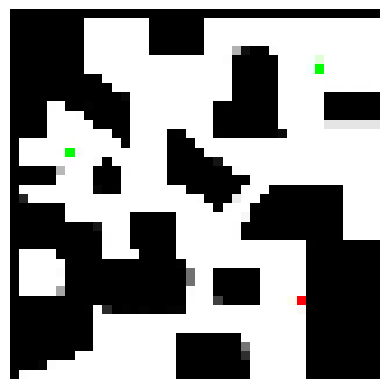

Matriz discretizada:
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 0 0 ... 1 1 1]]
Coordenadas del punto de inicio (rojo): (31, 31)
Coordenadas de los puntos finales (verdes): [(6, 33), (15, 6)]


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def discretize_image_and_matrix(image_path, pixel_size):
    # Abrir la imagen
    image = Image.open(image_path)
    image = image.convert('RGB')

    # Convertir la imagen a un array numpy
    image_array = np.array(image)
    height, width, _ = image_array.shape

    # Crear una nueva imagen con el tamaño adecuado para agregar el marco negro
    padded_height = height + 2 * pixel_size
    padded_width = width + 2 * pixel_size
    padded_image_array = np.zeros((padded_height, padded_width, 3), dtype=np.uint8)

    # Agregar el marco negro alrededor de la imagen original
    padded_image_array[pixel_size:pixel_size + height, pixel_size:pixel_size + width, :] = image_array

    # Ajustar las dimensiones de la imagen para que sean múltiplos de pixel_size
    new_height = (padded_height // pixel_size) * pixel_size
    new_width = (padded_width // pixel_size) * pixel_size
    padded_image_array = padded_image_array[:new_height, :new_width]

    discretized_height = new_height // pixel_size
    discretized_width = new_width // pixel_size
    discretized_img = np.zeros((discretized_height, discretized_width, 3), dtype=np.uint8)
    discretized_matrix = np.zeros((discretized_height, discretized_width), dtype=np.uint8)

    start_point = None
    end_points = []

    for i in range(0, new_height, pixel_size):
        for j in range(0, new_width, pixel_size):
            region = padded_image_array[i:i + pixel_size, j:j + pixel_size, :]

            # Tomar el color del primer píxel de la región
            pixel_color = region[pixel_size // 2, pixel_size // 2, :]
            discretized_img[i // pixel_size, j // pixel_size, :] = pixel_color

            # Identificar y cambiar píxeles grises a negro por su código RGB
            if np.all(region[:, :, 0] >= 0) and np.all(region[:, :, 0] <= 225):
                pixel_color = [0, 0, 0]  # Cambiar a color negro
            
            # Asignar valor a la matriz discretizada
            if np.all(pixel_color == [0, 0, 0]):
                discretized_matrix[i // pixel_size, j // pixel_size] = 1  # Representa una pared
            elif np.all(pixel_color >= [0, 200, 0]) and np.all(pixel_color <= [50, 255, 50]):
                discretized_matrix[i // pixel_size, j // pixel_size] = 0  # Representa el objetivo (verde)
                end_points.append((i // pixel_size, j // pixel_size))  # Guardar coordenadas del punto final
            elif np.all(pixel_color >= [220, 0, 0]) and np.all(pixel_color <= [255, 50, 50]):
                discretized_matrix[i // pixel_size, j // pixel_size] = 0  # Representa el inicio (rojo)
                start_point = (i // pixel_size, j // pixel_size)  # Guardar coordenadas del punto de inicio

    return discretized_img, discretized_matrix, start_point, end_points

def plot_discretized_image(discretized_img):
    plt.imshow(discretized_img)
    plt.axis('off')
    plt.show()

# Ruta de la imagen y tamaño de píxel deseado
image_path = "Test.bmp"
pixel_size = 15  # Ajusta el tamaño del píxel según sea necesario

# Discretizar la imagen y obtener la matriz discretizada
discretized_img, discretized_matrix, start_point, end_points = discretize_image_and_matrix(image_path, pixel_size)

# Visualizar la imagen discretizada
plot_discretized_image(discretized_img)

# Mostrar la matriz discretizada
print("Matriz discretizada:")
print(discretized_matrix)

# Mostrar las coordenadas del punto de inicio (rojo) y de los puntos finales (verdes)
print("Coordenadas del punto de inicio (rojo):", start_point)
print("Coordenadas de los puntos finales (verdes):", end_points)


## Task 1.2 Framework de Problemas
Usar interfaz genérica o abstracta que sirva para representar el framework para definir el problema formal. Se debe utilizar la matriz obtenida del Task 1.1 y con esta deberá deducir las demás funciones del framework. (actions(s), stepCost(s,a,s), etc). Debe utilizar efectivamente los conceptos del paradigma POO. 

In [58]:
from abc import ABC, abstractmethod
from typing import List, Tuple

class SearchAlgorithm(ABC):
    def __init__(self, maze: List[List[int]]):
        self.maze = maze
        self.rows = len(maze)
        self.columns = len(maze[0]) if self.rows > 0 else 0

    # Verifica si un movimiento es válido
    def valid_move(self, position: Tuple[int, int]) -> bool:
        row, column = position
        if 0 <= row < self.rows and 0 <= column < self.columns:
            return self.maze[row][column] == 0  # 0 representa un camino libre
        return False
    
    @abstractmethod
    def actions(self, position: Tuple[int, int]) -> List[Tuple[int, int]]:
        pass
    
    @abstractmethod
    def step_cost(self, current: Tuple[int, int], next: Tuple[int, int]) -> int:
        pass
    
    @abstractmethod
    def search(self, start: Tuple[int, int], goal: Tuple[int, int]) -> List[Tuple[int, int]]:
        pass

## Task 1.3 Graph-Search 
Construir el algoritmo genérico (familia de graphSearch). Este recibirá de parámetro una instancia del framework de problemas. Implemente los siguientes algoritmos:
- Breadth First Search (BFS)
- Depth First Search (DFS)
- A* (escoger dos heurísticas, justificar elección)

## TASK 1.3
### Breadth First Search (BFS)

## TASK 1.3
### Depth First Search (DFS)

In [62]:
class DFSAlgorithm(SearchAlgorithm):
    def __init__(self, maze: List[List[int]]):
        super().__init__(maze)
    
    def actions(self, position: Tuple[int, int]) -> List[Tuple[int, int]]:
        row, col = position
        possible_actions = [(row-1, col), (row+1, col), (row, col-1), (row, col+1)]
        valid_actions = [action for action in possible_actions if self.valid_move(action)]
        return valid_actions
    
    def step_cost(self, current: Tuple[int, int], next: Tuple[int, int]) -> int:
        return 1
    
    def search(self, start: Tuple[int, int], goal: Tuple[int, int], max_depth: int = float('inf')) -> List[Tuple[int, int]]:
        visited = set()
        path = []
        stack = [(start, 0)]

        while stack:
            current, depth = stack.pop()
            if current == goal:
                path.append(current)
                return path

            if depth < max_depth:
                if current not in visited:
                    visited.add(current)
                    path.append(current)

                    possible_actions = self.actions(current)
                    stack.extend([(next_action, depth + 1) for next_action in possible_actions])

        return []
        
dfs_algorithm = DFSAlgorithm(discretized_matrix)

result_path = dfs_algorithm.search(start_point, end_points[0])

print("Camino encontrado:", result_path)

Camino encontrado: [(31, 31), (31, 30), (31, 29), (31, 28), (31, 27), (32, 27), (32, 28), (32, 29), (32, 30), (32, 31), (33, 31), (33, 30), (33, 29), (33, 28), (33, 27), (33, 26), (33, 25), (33, 24), (33, 23), (33, 22), (33, 21), (33, 20), (33, 19), (33, 18), (33, 17), (33, 16), (33, 15), (33, 14), (33, 13), (33, 12), (33, 11), (33, 10), (33, 9), (34, 9), (34, 10), (34, 11), (34, 12), (34, 13), (34, 14), (34, 15), (34, 16), (34, 17), (34, 18), (34, 19), (34, 20), (34, 21), (34, 22), (34, 23), (34, 24), (34, 25), (34, 26), (34, 27), (34, 28), (34, 29), (34, 30), (34, 31), (35, 31), (35, 30), (35, 29), (35, 28), (35, 27), (35, 26), (35, 25), (36, 25), (36, 26), (36, 27), (36, 28), (36, 29), (36, 30), (36, 31), (37, 31), (37, 30), (37, 29), (37, 28), (37, 27), (37, 26), (37, 25), (38, 26), (38, 27), (38, 28), (38, 29), (38, 30), (38, 31), (39, 31), (39, 30), (39, 29), (39, 28), (39, 27), (39, 26), (35, 18), (35, 17), (35, 16), (35, 15), (35, 14), (35, 13), (35, 12), (35, 11), (35, 10), (3

## TASK 1.3
### A* 

In [6]:
# Incluir ambas heurísticas aquí
import heapq

class AStarSearch(SearchAlgorithm):
    def actions(self, position: Tuple[int, int]) -> List[Tuple[int, int]]:
        # Define potential moves: Right, Down, Left, Up
        potential_moves = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        # Return only valid moves based on is_valid_move
        return [(position[0] + move[0], position[1] + move[1]) for move in potential_moves if self.is_valid_move((position[0] + move[0], position[1] + move[1]))]
    

    # Distancia de Manhattan
    def heuristic(self, current: Tuple[int, int], goal: Tuple[int, int]) -> int:
        return abs(current[0] - goal[0]) + abs(current[1] - goal[1])


    def search(self, start: Tuple[int, int], goal: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
        frontier = []
        heapq.heappush(frontier, (0 + self.heuristic(start, goal), 0, start))  
        came_from = {start: None}
        cost_so_far = {start: 0}

        while frontier:
            current_f, current_g, current = heapq.heappop(frontier)

            if current == goal:
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                return path[::-1]  # Reverse path

            for next in self.actions(current):
                new_cost = cost_so_far[current] + 1  # asumiendo el costo es 1
                if next not in cost_so_far or new_cost < cost_so_far[next]:
                    cost_so_far[next] = new_cost
                    priority = new_cost + self.heuristic(next, goal)
                    heapq.heappush(frontier, (priority, new_cost, next))
                    came_from[next] = current

        return None 
astar = AStarSearch(discretized_matrix)
print(astar.search((22,22), [(4, 12), (9, 2)]))


TypeError: Can't instantiate abstract class AStarSearch with abstract method step_cost

## TASK 1.4
Resolver el laberinto de entrada y mostrar en pantalla gráficamente el camino encontrado. **Su representación se basará en la matriz discreta, no en la imagen original.**  

### TASK 1.3
#### Depth First Search (DFS)

Camino encontrado: [(31, 31), (31, 30), (31, 29), (31, 28), (31, 27), (32, 27), (32, 28), (32, 29), (32, 30), (32, 31), (33, 31), (33, 30), (33, 29), (33, 28), (33, 27), (33, 26), (33, 25), (33, 24), (33, 23), (33, 22), (33, 21), (33, 20), (33, 19), (33, 18), (33, 17), (33, 16), (33, 15), (33, 14), (33, 13), (33, 12), (33, 11), (33, 10), (33, 9), (34, 9), (34, 10), (34, 11), (34, 12), (34, 13), (34, 14), (34, 15), (34, 16), (34, 17), (34, 18), (34, 19), (34, 20), (34, 21), (34, 22), (34, 23), (34, 24), (34, 25), (34, 26), (34, 27), (34, 28), (34, 29), (34, 30), (34, 31), (35, 31), (35, 30), (35, 29), (35, 28), (35, 27), (35, 26), (35, 25), (36, 25), (36, 26), (36, 27), (36, 28), (36, 29), (36, 30), (36, 31), (37, 31), (37, 30), (37, 29), (37, 28), (37, 27), (37, 26), (37, 25), (38, 26), (38, 27), (38, 28), (38, 29), (38, 30), (38, 31), (39, 31), (39, 30), (39, 29), (39, 28), (39, 27), (39, 26), (35, 18), (35, 17), (35, 16), (35, 15), (35, 14), (35, 13), (35, 12), (35, 11), (35, 10), (3

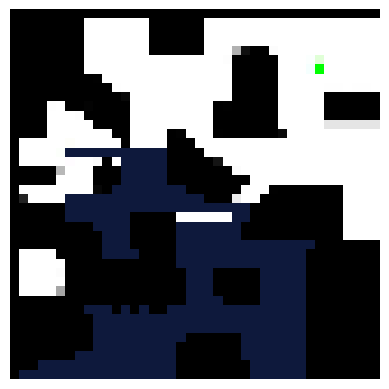

In [61]:
def plotWithPath(discretized_img, result_path):
    # Crear una copia de la imagen discretizada para no modificar la original
    img_with_path = np.copy(discretized_img)

    # Resaltar el camino en la copia de la imagen
    for point in result_path:
        y, x = point
        img_with_path[y, x, :] = [14, 25, 60]  # Resaltar el camino en rojo

    plt.imshow(img_with_path)
    plt.axis('off')
    plt.show()

# Crear una instancia de DFSAlgorithm y ejecutar la búsqueda
dfs_algorithm = DFSAlgorithm(discretized_matrix)

result_path = dfs_algorithm.search(start_point, end_points[1])

print("Camino encontrado:", result_path)

# Visualizar la imagen discretizada con el camino resultante
plotWithPath(discretized_img, result_path)